In [ ]:
import os
import numpy as np
import requests
from PIL import Image, ImageDraw
import torch
from torch.utils.data import DataLoader, Dataset

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms import ToTensor
from torchvision.transforms.v2 import functional as F

from transformers import OwlViTProcessor, OwlViTForObjectDetection

In [ ]:
class PennFudanDataset(Dataset):
    def __init__(self, root, image_processor):
        self.root = root
        self.annots_path = "PennFudanPed/Annotation"
        self.annots_list = os.listdir(os.path.join(self.root, self.annots_path))
        self.image_processor = image_processor

    def getimgPath(self, t):
        return t[1].split(' : ')[-1][1:-1]

    def getBBoxs(self, t, img_shape):
        ts = [x for x in t if 'Bounding box for object' in x]
        bboxes = []
        for tss in ts:
            ts1 = tss.split(' : ')[-1]
            bbox = []
            for tss1 in ts1.split(' - '):
                tss2 = tss1[1:-1].split(', ')
                bbox.append(float(tss2[0])/img_shape[0])
                bbox.append(float(tss2[1])/img_shape[1])
            bboxes.append(bbox)
        return np.array(bboxes)

    def __getitem__(self, idx):
        annot_path = os.path.join(self.root, self.annots_path, self.annots_list[idx])
        annot_info = open(annot_path).read().split('\n')
        imgPath = self.getimgPath(annot_info)

        img_path = os.path.join(self.root, imgPath)
        img = Image.open(img_path)
        boxes = self.getBBoxs(annot_info, img.size)
        num_objs = len(boxes)

        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        img = ToTensor()(img.resize((768, 768)))

        target = {}
        target["boxes"] = torch.Tensor(boxes)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        target['img_path'] = img_path

        img_pixels = image = self.image_processor(images=img, return_tensors="pt")["pixel_values"].squeeze(0)

        return img, target['labels'], target['boxes'], target

    def __len__(self):
        return len(self.annots_list)

In [2]:
processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")

preprocessor_config.json:   0%|          | 0.00/392 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/4.42k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/613M [00:00<?, ?B/s]

In [4]:
dataset = PennFudanDataset('/kaggle/input/pennfudanped/', processor)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=1)

In [5]:
texts = [["Person"]]
inputs = processor(text=texts, return_tensors="pt")
input_ids = inputs['input_ids']
attention_mask = inputs['attention_mask']

In [ ]:
for pixel_values, labels, bboxs, meta in dataloader:
    outputs = model(pixel_values = pixel_values, input_ids = input_ids, attention_mask = attention_mask)
    break

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
image = Image.open(meta['img_path'][0])
target_sizes = torch.Tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs=outputs, threshold=0.01, target_sizes=target_sizes)

i = 0
text = texts[i]
boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]
img1 = ImageDraw.Draw(image)
for box, score, label in zip(boxes, scores, labels):
    box = [int(i) for i in box.tolist()]
    shape = [(box[0], box[1]), (box[2], box[3])]
    img1.rectangle(shape, outline ="red")
    print(f"Detected {text[label]} with confidence {round(score.item(), 3)} at location {box}")

Detected Person with confidence 0.013 at location [511, 24, 569, 108]
Detected Person with confidence 0.011 at location [512, 63, 574, 121]
Detected Person with confidence 0.041 at location [544, 61, 588, 123]
Detected Person with confidence 0.011 at location [575, 34, 671, 174]
Detected Person with confidence 0.037 at location [173, 53, 266, 340]
Detected Person with confidence 0.018 at location [356, 62, 429, 163]
Detected Person with confidence 0.042 at location [359, 65, 426, 159]
Detected Person with confidence 0.029 at location [385, 60, 486, 261]
Detected Person with confidence 0.014 at location [481, 79, 565, 146]
Detected Person with confidence 0.043 at location [578, 30, 690, 390]
Detected Person with confidence 0.056 at location [18, 60, 125, 342]
Detected Person with confidence 0.05 at location [387, 57, 491, 355]
Detected Person with confidence 0.014 at location [382, 58, 485, 330]
Detected Person with confidence 0.013 at location [449, 65, 552, 313]
Detected Person with c

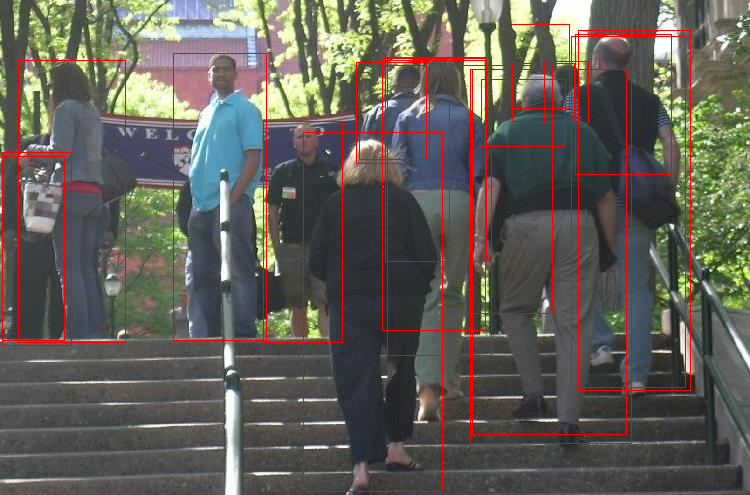

In [11]:
image